https://mybinder.org/v2/gh/openvinotoolkit/openvino_notebooks/HEAD?filepath=notebooks%2F201-vision-monodepth%2F201-vision-monodepth.ipynb

https://docs.openvino.ai/2023.1/get_started.html


Monocular Depth Estimation is the task of estimating scene depth using a single image. It has many potential applications in robotics, 3D reconstruction, medical imaging and autonomous systems. This tutorial uses a neural network model called MiDaS, which was developed by the Embodied AI Foundation. See the research paper below to learn more.

R. Ranftl, K. Lasinger, D. Hafner, K. Schindler and V. Koltun, "Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer," in IEEE Transactions on Pattern Analysis and Machine Intelligence, doi: 10.1109/TPAMI.2020.3019967.

In [2]:
%pip install -q "openvino>=2023.1.0"

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

('notebook_utils.py', <http.client.HTTPMessage at 0x240ef69cad0>)

In [1]:
import time
from pathlib import Path

import cv2
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import (
    HTML,
    FileLink,
    Pretty,
    ProgressBar,
    Video,
    clear_output,
    display,
)
import openvino as ov

from notebook_utils import download_file, load_image

# Download the model 

In [2]:
model_folder = Path('model')

ir_model_url = 'https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/depth-estimation-midas/FP32/'
ir_model_name_xml = 'MiDaS_small.xml'
ir_model_name_bin = 'MiDaS_small.bin'

download_file(ir_model_url + ir_model_name_xml, filename=ir_model_name_xml, directory=model_folder)
download_file(ir_model_url + ir_model_name_bin, filename=ir_model_name_bin, directory=model_folder)

model_xml_path = model_folder / ir_model_name_xml

'model\MiDaS_small.xml' already exists.
'model\MiDaS_small.bin' already exists.


In [6]:
model_xml_path

WindowsPath('model/MiDaS_small.xml')

In [4]:
def normalize_minmax(data):
    """Normalizes the values in `data` between 0 and 1"""
    return (data - data.min()) / (data.max() - data.min())


def convert_result_to_image(result, colormap="viridis"):
    """
    Convert network result of floating point numbers to an RGB image with
    integer values from 0-255 by applying a colormap.

    `result` is expected to be a single network result in 1,H,W shape
    `colormap` is a matplotlib colormap.
    See https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    cmap = matplotlib.cm.get_cmap(colormap)
    result = result.squeeze(0)
    result = normalize_minmax(result)
    ## It applies the colormap to result using cmap(result). This maps the floating-point values to colors according to the chosen colormap.
    #t selects only the first three channels of the resulting colormap image using [:, :, :3]. This step is necessary because some colormaps
    # may produce images with more than three channels (e.g., RGBA), and you want to keep only the RGB channels.
    result = cmap(result)[:, :, :3] * 255   
    result = result.astype(np.uint8)
    return result


def to_rgb(image_data) -> np.ndarray:
    """
    Convert image_data from BGR to RGB
    """
    return cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

# Select device from dropdown list for running inference using OpenVINO

In [5]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

In [6]:
device.value

'AUTO'

# Load the Model 

MiDaS (Monocular Depth Estimation) model with OpenVINO and  the files MiDaS_small.bin and MiDaS_small.xml. These files  represent the model weights and configuration in the OpenVINO Intermediate Representation (IR) format. 

Load the model in OpenVINO Runtime with core.read_model and compile it for the specified device with core.compile_model. Get input and output keys and the expected input shape for the model.



In [7]:
core = ov.Core()
core.set_property({'CACHE_DIR': '../cache'})
model = core.read_model(model_xml_path)
compiled_model = core.compile_model(model=model, device_name=device.value)

In [26]:
compiled_model  # openvino.runtime.ie_api.CompiledModel

<CompiledModel:
inputs[
<ConstOutput: names[input.1] shape[1,3,256,256] type: f32>
]
outputs[
<ConstOutput: names[1349] shape[1,256,256] type: f32>
]>

# network_image_height - network_image_width from Compiled Model 

In [8]:
input_key = compiled_model.input(0)
output_key = compiled_model.output(0)

input_key

<ConstOutput: names[input.1] shape[1,3,256,256] type: f32>

In [9]:
output_key

<ConstOutput: names[1349] shape[1,256,256] type: f32>

In [10]:
network_input_shape = list(input_key.shape)
network_image_height, network_image_width = network_input_shape[2:]  # 255 , 255 

In [11]:
network_input_shape

[1, 3, 256, 256]

# Load and Resize an image to feed in Net 

Load, resize and reshape input image 
 
The input image is read with OpenCV, resized to network input size, and reshaped to (N,C,H,W) (N=number of images, C=number of channels, H=height, W=width).

In [12]:
IMAGE_FILE = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg"
image = load_image(path=IMAGE_FILE)

image.shape

(600, 800, 3)

In [13]:
# Resize to input shape for network.
resized_image = cv2.resize(src=image, dsize=(network_image_height, network_image_width))
resized_image.shape

(256, 256, 3)

In [14]:
# Reshape the image to network input shape NCHW.
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)
input_image.shape

(1, 3, 256, 256)

# Monodepth on Image 

In [15]:
result = compiled_model([input_image])[output_key]

result.shape

(1, 256, 256)

In [28]:
type(result)

numpy.ndarray

# Convert Result to Image

In [16]:
# Convert the network result of disparity map to an image that shows
# distance as colors.
result_image = convert_result_to_image(result=result)
result_image.shape


C:\Users\pooya\AppData\Local\Temp\ipykernel_11632\2927301382.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(colormap)


(256, 256, 3)

# Resize Back to Original Image Shape and Plot Original Image and Result (Depth Map)

In [18]:
# Resize back to original image shape. The `cv2.resize` function expects shape
# in (width, height), [::-1] reverses the (height, width) shape to match this.
result_image = cv2.resize(result_image, image.shape[:2][::-1])  # (800, 600)

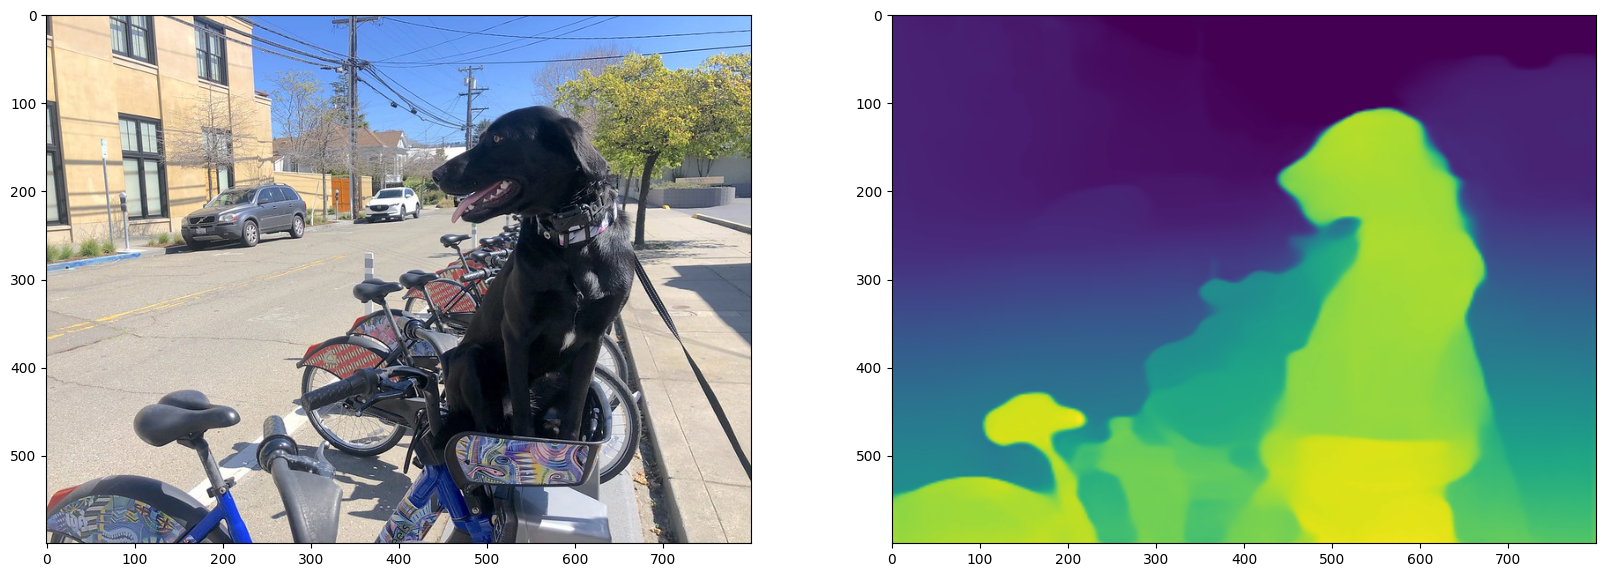

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(to_rgb(image))
ax[1].imshow(result_image);

# Monodepth on Video  
 
By default, only the first 100 frames are processed in order to quickly check that everything works. Change NUM_FRAMES in the cell below to modify this. Set NUM_FRAMES to 0 to process the whole video.

In [58]:
# Video source: https://www.youtube.com/watch?v=fu1xcQdJRws (Public Domain)
VIDEO_FILE = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4"
# Number of seconds of input video to process. Set `NUM_SECONDS` to 0 to process
# the full video.
NUM_SECONDS = 0
# Set `ADVANCE_FRAMES` to 1 to process every frame from the input video
# Set `ADVANCE_FRAMES` to 2 to process every second frame. This reduces
# the time it takes to process the video.
ADVANCE_FRAMES = 2
# Set `SCALE_OUTPUT` to reduce the size of the result video
# If `SCALE_OUTPUT` is 0.5, the width and height of the result video
# will be half the width and height of the input video.
SCALE_OUTPUT = 0.5
# The format to use for video encoding. The 'vp09` is slow,
# but it works on most systems.
# Try the `THEO` encoding if you have FFMPEG installed.
# FOURCC = cv2.VideoWriter_fourcc(*"THEO")
FOURCC = cv2.VideoWriter_fourcc(*"vp09")

# Create Path objects for the input video and the result video.
output_directory = Path("output")
output_directory.mkdir(exist_ok=True)
result_video_path = output_directory / f"{Path(VIDEO_FILE).stem}_monodepth.mp4"

# Load the Video 

In [59]:
cap = cv2.VideoCapture(str(VIDEO_FILE)) # access individual frames of video for processing.

ret, image = cap.read()  # ret : Bool , image : numpy array 

if not ret:
    raise ValueError(f"The video at {VIDEO_FILE} cannot be read.")




# Configuration of Output Video Size and FPS 

In [60]:
# to retrieve the frames per second (FPS) of the video source
input_fps = cap.get(cv2.CAP_PROP_FPS)  

input_video_frame_height, input_video_frame_width = image.shape[:2]  # 360, 640

#  to process only every second frames. 
target_fps = input_fps / ADVANCE_FRAMES  

# to reduce the size of the result video
target_frame_height = int(input_video_frame_height * SCALE_OUTPUT)
target_frame_width = int(input_video_frame_width * SCALE_OUTPUT)

cap.release()
print(
    f"The input video has a frame width of {input_video_frame_width}, "
    f"frame height of {input_video_frame_height} and runs at {input_fps:.2f} fps"
)
print(
    "The monodepth video will be scaled with a factor "
    f"{SCALE_OUTPUT}, have width {target_frame_width}, "
    f" height {target_frame_height}, and run at {target_fps:.2f} fps"
)

The input video has a frame width of 640, frame height of 360 and runs at 30.00 fps
The monodepth video will be scaled with a factor 0.5, have width 320,  height 180, and run at 15.00 fps


# Apply Video Input Configuration and Do Inference on a Video and Create Monodepth Video

In [61]:
# Initialize variables.
input_video_frame_nr = 0
start_time = time.perf_counter()
total_inference_duration = 0

# Open the input video
cap = cv2.VideoCapture(str(VIDEO_FILE))

# VideoWriter object using OpenCV
# to write video frames to an output video file 
out_video = cv2.VideoWriter(
    str(result_video_path),
    FOURCC,  #FourCC codec identifier
    target_fps, 
    (target_frame_width * 2, target_frame_height),
)

num_frames = int(NUM_SECONDS * input_fps)
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) if num_frames == 0 else num_frames
progress_bar = ProgressBar(total=total_frames)
progress_bar.display()

try:
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            cap.release()
            break

        if input_video_frame_nr >= total_frames:
            break

        # Only process every second frame.
        # Prepare a frame for inference.
        # Resize to the input shape for network.
        resized_image = cv2.resize(src=image, dsize=(network_image_height, network_image_width))
        # Reshape the image to network input shape NCHW.
        input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)

        ###  Do inference.
        inference_start_time = time.perf_counter()
        result = compiled_model([input_image])[output_key]


        #  provide visual feedback on the progress of each video frame
        inference_stop_time = time.perf_counter()
        inference_duration = inference_stop_time - inference_start_time
        total_inference_duration += inference_duration
        if input_video_frame_nr % (10 * ADVANCE_FRAMES) == 0:
            clear_output(wait=True)
            progress_bar.display()
            # input_video_frame_nr // ADVANCE_FRAMES gives the number of
            # Frames that have been processed by the network.
            display(
                Pretty(
                    f"Processed frame {input_video_frame_nr // ADVANCE_FRAMES}"
                    f"/{total_frames // ADVANCE_FRAMES}. "
                    f"Inference time per frame: {inference_duration:.2f} seconds "
                    f"({1/inference_duration:.2f} FPS)"
                )
            )


        
        # Transform the network result to a RGB image.
        result_frame = to_rgb(convert_result_to_image(result))
        # Resize the image and the result to a target frame shape.
        result_frame = cv2.resize(result_frame, (target_frame_width, target_frame_height))
        image = cv2.resize(image, (target_frame_width, target_frame_height))
        
        # Put the image and the result side by side.
        stacked_frame = np.hstack((image, result_frame))
        # Save a frame to the video.
        out_video.write(stacked_frame)

        #  advance frame processing within a video processing loop
        input_video_frame_nr = input_video_frame_nr + ADVANCE_FRAMES
        cap.set(1, input_video_frame_nr)

        progress_bar.progress = input_video_frame_nr
        progress_bar.update()

except KeyboardInterrupt:
    print("Processing interrupted.")
    
finally:
    # releasing resources and final printing 
    clear_output()
    processed_frames = num_frames // ADVANCE_FRAMES
    out_video.release()
    cap.release()
    end_time = time.perf_counter()
    duration = end_time - start_time

    print(
        f"Processed {processed_frames} frames in {duration:.2f} seconds. "
        f"Total FPS (including video processing): {processed_frames/duration:.2f}."
        f"Inference FPS: {processed_frames/total_inference_duration:.2f} "
    )
    print(f"Monodepth Video saved to '{str(result_video_path)}'.")

Processed 0 frames in 66.88 seconds. Total FPS (including video processing): 0.00.Inference FPS: 0.00 
Monodepth Video saved to 'output\Coco%20Walking%20in%20Berkeley_monodepth.mp4'.


# Display Monodepth Video

In [55]:
video = Video(result_video_path, width=800, embed=True)
if not result_video_path.exists():
    plt.imshow(stacked_frame)
    raise ValueError("OpenCV was unable to write the video file. Showing one video frame.")
else:
    print(f"Showing monodepth video saved at\n{result_video_path.resolve()}")
    print(
        "If you cannot see the video in your browser, please click on the "
        "following link to download the video "
    )
    video_link = FileLink(result_video_path)
    video_link.html_link_str = "<a href='%s' download>%s</a>"
    display(HTML(video_link._repr_html_()))
    display(video)

Showing monodepth video saved at
C:\Users\pooya\Desktop\python projects\24 - Driver Monitoring - Gaza Detection\output\Coco%20Walking%20in%20Berkeley_monodepth.mp4
If you cannot see the video in your browser, please click on the following link to download the video 
